## Linear transformations

*Linear algebra, affine transformations, generalized least squares, interactive Jupyter*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<p style="text-align: right"><i>Classification of mathematical problems as linear and nonlinear is like classification of the Universe as bananas and non-bananas.</i></p>

At this stage, you are hopefully able to extract sources from an astronomical image and calculate their centroids (otherwise, see the "Source extraction" notebook). The result of this operation is a set of pairs of pixel coordinates, which we will denote with $x_m$ and $y_m$ ($m$ for "measured").

Additionally, you should be able to query the field of interest from an astronomical catalogue (and if you are not, see the "Astronomical Catalogues" notebook) and convert the provided celestial coordinates (RA and Dec) into the so-called "standard" coordinates, which we will denote with $x_c$ and $y_c$ ($c$ for "catalogue"). After assuming the CCD to be ideal and perhaps manually translating your $x_c$ and $y_c$, you got them to almost match $x_m$ and $y_m$, but not quite.

This is where this session begins. This notebook will explore some of the linear algebra routines built in NumPy that will allow us to leave the ideal CCD assumption behind and compute the exact transformation that links any set of celestial coordinates on the sky to the exact pixel position on the CCD. Astronomers often call this transformation a *plate solution*.

For the purposes of this notebook only, we will use a sample dataset. It is left up to the students to extend the techniques demonstrated below to their astronomical images. The sample dataset can now be downloaded from GitHub. It includes two files: `measured.dat` with $x_m$ and $y_m$ and `catalogue.dat` with $x_c$ and $y_c$. Let us plot them on the same set of axes to see what they look like:

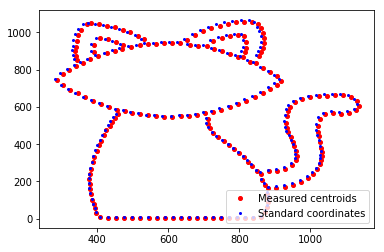

In [2]:
data_dir = './CAT_data/'         #  Point this to your file system

x_m, y_m = np.loadtxt(data_dir + 'measured.dat', unpack = True)
plt.plot(x_m, y_m, 'ro', label = "Measured centroids", ms = 4)
x_c, y_c = np.loadtxt(data_dir + 'catalogue.dat', unpack = True)
plt.plot(x_c, y_c, 'bo', label = "Standard coordinates", ms = 2)
plt.legend()

In principle, the plate could experience complex distortions and require arbitrarily sophisticated models to be solved. In this lab, however, we will restrict ourselves to the most basic types of transformations: translation, magnification, rotation and shear. The one thing all four have in common is *linearity*, which means that they all can be written out as a matrix and manipulated using the tools of *linear algebra*. NumPy comes with a suite of built-in linear algebra routines, which is where we start.

<div class="alert alert-info">
    <b>FYI:</b> Strictly speaking, <i>translation</i> is <b>not</b> a linear transformation, because $A(x + x_0) \neq A(x) + x_0$. Hence, <i>translation</i> cannot be represented with a matrix without introducing additional dimensions. This is exactly what we are going to do: we will add a "fake" third dimension (aka matrix augmentation) to allow translations. A more general term that includes both linear transformations and translations is <i>affine transformations</i>. As physicists, however, we are allowed to abuse mathematical terminology and use the two terms interchangeably in this notebook.
</div>

And oh yeah, the credit for the constellation of Feles Major goes to [Rauno Tolonen](https://easydrawingguides.com/how-to-draw-a-simple-cat/).

## NumPy linear algebra

As powerful as NumPy arrays may be, they **do not** behave like vectors and matrices by default. For example...

In [3]:
a = np.array([[1, 2], [3, 4]])  # Some random "matrix"
b = np.array([[1, 0], [0, 1]])  # The identity "matrix"

print a * b # Should be the same as "a" (by matrix multiplication), but it won't be

[[1 0]
 [0 4]]


...when multiplying two 2D arrays, Python will carry out the multiplication element by element instead of performing a proper matrix multiplication. However, there are at least two ways to make Python respect matrix multiplication rules. In the simplest case, the multiplication can be performed with `np.dot()`:

In [4]:
print np.dot(a, b) # Remains the same as "a" because it is matrix-multiplied by identity

[[1 2]
 [3 4]]


Alternatively, we could typecast `a` and `b` into a matrix datatype with `np.matrix()`. Variables of this type behave like ordinary matrices:

In [5]:
a = np.matrix(a); b = np.matrix(b)

print a * b

[[1 2]
 [3 4]]


Even better, we can now apply mathematical operators and they will be handled "the matrix way". E.g.:

In [6]:
print "wake up neo"

# Matrix power
print a ** 2

wake up neo
[[ 7 10]
 [15 22]]


Nonetheless, be advised that this does not extend to built-in mathematical functions like `np.log()` and the like. If you need to apply one of those to your matrix (an unlikely situation in this course), use [specialized implementations](https://docs.scipy.org/doc/scipy-0.15.1/reference/linalg.html).

Just like everything else, matrices are objects with properties. The most relevant properties here will be `.I` which returns the inverse and `.T` which returns the transpose:

In [7]:
# Matrix inverse
print a.I

# Matrix transpose
print a.T

[[-2.   1. ]
 [ 1.5 -0.5]]
[[1 3]
 [2 4]]


From your linear algebra course, you might remember that inverting a matrix is equivalent to solving a system of simultaneous first-order equations. For example, consider the following system:

$$
\begin{cases}
1x + 2y =5 \\
3x + 4y = 6
\end{cases}
$$

the system may be solved using matrices:

In [8]:
M = np.matrix([[1, 2], [3, 4]]).T    # Matrices can be created from lists too!
b = np.matrix([5, 6])                # Vectors are nothing more than 1D matrices here

a = b * M.I

# A matrix will require two indices even if it's a vector, as Python needs to somehow remember whether this is a
# column vector or a row vector
print "x =", a[0, 0]
print "y =", a[0, 1]

x = -4.0
y = 4.5


Have a closer look at `M` in the code cell above. The number of rows corresponds to the number of variables (in our case, there are two: $x$ and $y$). The number of columns corresponds to the number of equations (again, two here). Assuming the system to be fully linearly independent, the number of columns must match the number of rows to be solvable exactly, i.e. the matrix must be square.

If the number of variables (rows) is less than the number of equations (columns), the system is called *underdetermined*. An underdetermined system does not contain enough information to be fully solvable. Yet, Python is able to compute the inverse of `M` without errors:

In [9]:
M = np.matrix([[1, 2, 3], [4, 5, 6]]).T
print M.I

[[-0.94444444 -0.11111111  0.72222222]
 [ 0.44444444  0.11111111 -0.22222222]]


Disappointingly, this is not black magic (yet). Python is smart enough to see that the system is underdetermined. In such cases, it automatically redefines `.I` to compute the so-called *pseudoinverse* matrix instead, whose symbolic definition is:

$$M^{+} = (M^T M)^{-1}\ M^T$$

where the superscripts $+$, $-1$ and $T$ stand for pseudoinverse, inverse and transpose respectively. In fact, this behavior can be suppressed if instead of `.I` we either call `np.linalg.inv()` for the standard inverse or `np.linalg.pinv()` for the pseudoinverse:

In [10]:
# First, compute the pseudoinverse (should be the same as M.I)
print np.linalg.pinv(M)

# Now, compute the pseudoinverse using the formula (should, again, be the same)
print np.linalg.inv(M.T * M) * M.T

# Now try to compute the regular inverse (won't work, because the system is underdetermined)
print np.linalg.inv(M)   # ERROR!

[[-0.94444444 -0.11111111  0.72222222]
 [ 0.44444444  0.11111111 -0.22222222]]
[[-0.94444444 -0.11111111  0.72222222]
 [ 0.44444444  0.11111111 -0.22222222]]


LinAlgError: Last 2 dimensions of the array must be square

Pseudoinverse matrices can be incredibly useful. For underdetermined systems, they give *one* of the possible solutions, which is sometimes needed. Of course, there will be other solutions too, as the system does not contain enough information to pinpoint one specific solution.

The true power of pseudoinverse is revealed when it is applied to *overdetermined* systems. Such systems have more equations than variables and, hence, contain "too much" information. In other words, this means that individual equations contradict each other and cannot be solved *precisely*. Nonetheless, one may still attempt to find a solution that *approximates* all the equations as closely as possible. I.e., one may attempt a least squares optimization. Most important, this optimized least squares solution is exactly what the pseudoinverse gives us when the system is overdetermined.

For example, we can use the pseudoinverse to fit a straight line to a dataset. The relevant system of equations in this case is:

$$
\begin{cases}
x_1m  + 1c = y_1 \\
x_2m  + 1c = y_2 \\
x_3m  + 1c = y_3 \\
\dots
\end{cases}
$$

where $m$ and $c$ are the best-fit parameters and $y_n$ and $x_n$ are the data series.

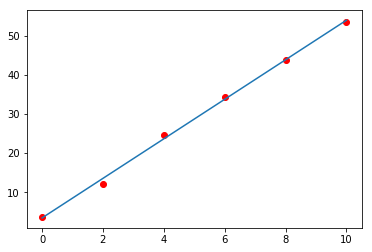

In [11]:
# Create a test dataset (with noise)
x = np.linspace(0, 10, 6)
y = 5 * x + 2 + np.random.normal(0, 2, 6)
plt.plot(x, y, 'ro')

# Now use pseudoinverses to get the best fit line
M = np.matrix([x, np.ones(len(x))])       # Set up our overdetermined system. np.ones() returns an array of ones
b = np.matrix(y)
coef = b * np.linalg.pinv(M)

# Plot the fit out
plt.plot(x, np.poly1d(np.array(coef)[0])(x))

The concept of a pseudoinverse matrix is very relevant to this lab, as we will attempt to solve the plate by using a very large number of identified stars as data points. The plate solution will be made of translation, magnification, shear and rotation, all of which can be described by six constant parameters, as we will see in a moment. Since the number of stars is much larger than six (it better be!), the system is overdetermined and calls for a least squares fit. Instead of computing one ourselves, we can let pseudoinverse do the job.

## Interactive transformations

The rotation matrix can be written as follows:

$$T_{\rm rot}=\begin{pmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) &  \cos(\theta) & 0 \\
0 &  0 & 1
\end{pmatrix}$$

where rotation happens anticlockwise by angle $\theta$. Let us use this matrix to rotate $x_c$ and $y_c$ (the catalogue standard coordinates) by $30$ degrees:

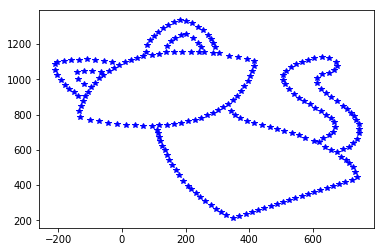

In [12]:
def T_rot(theta):
    '''Docstring!'''
    # Degrees to radians
    theta = np.pi * theta / 180
    
    return np.matrix([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

# Load the coordinates one more time just in case
x_c, y_c = np.loadtxt(data_dir + 'catalogue.dat', unpack = True)

# First, prepare the vector to be transformed, (x_c, y_c, 1).
vector = np.matrix([x_c, y_c, 1]).T # ".T" (transpose) will make it a column vector

# Apply the transformation
vector_t = np.array(T_rot(30) * vector)

# Extract the first two components out of the vector (the third components should be just ones)
x_c_t, y_c_t = vector_t[0:2,0]

plt.plot(x_c_t, y_c_t, 'b*')

In Jupyter notebooks, it is possible to create an interactive plot, i.e. one that has GUI controls (checkboxes, buttons, sliders etc) that can be clicked on, immediately affecting the plot (or, in fact, any output that you may have). The most basic type of interactions is realized in a module called *ipywidgets*. This module may or may not be installed depending on your version of *Anaconda*. First, try running the cell below. If it runs, you're in luck!

If it does not, head to your *Anaconda prompt* (or your usual terminal on *Mac OS* and *Linux*) and run the following:

```
pip install ipywidgets
```

When the installation completes, restart your kernel (Kernel -> Restart) and rerun the cells in your notebook up to this one. As before, should errors arise, save the output of the terminal and get in touch! After the install, you should be able to run the cell below:

In [13]:
from ipywidgets import interact, fixed, IntSlider, FloatSlider

Now your Python is truly interactive! To use the new feature, we need to write a single function that does both the transformation and the plotting. I will create a universal function that works with any single-parameter transformation matrix, $T$:

In [14]:
def plot_transformation(T, x, y, arg):
    """ Applies a single-parameter transfromation T (the parameter is arg) to an (x, y) dataset and plots the result"""
    vector = np.matrix([x, y, 1]).T
    vector_t = np.array(T(arg) * vector)
    x_t, y_t = vector_t[0:2,0]
    plt.plot(x_t, y_t, 'b*')
    plt.xlim(-1400, 1400)
    plt.ylim(-1400, 1400)

Now let's create an interactive plot! After running the cell below, you should be able to drag the slider to rotate your data by any number of degrees.

In [15]:
# Create a widget object first. The widget will be an integer slider, allowing us to choose the angle of rotation.
# ipywidgets needs to know the desired minimum and maximum values, the initial value (0) and the step size
widget = IntSlider(min = 0, max = 360, step = 10, value = 0)

# Next, create the plot! fixed() will tell ipywidgets that those arguments do not need widgets and have
# fixed values instead. The ";" at the end will suppress any default Python output.
interact(plot_transformation, arg = widget, T = fixed(T_rot), x = fixed(x_c), y = fixed(y_c));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2FyZycsIG1heD0zNjAsIHN0ZXA9MTApLCBPdXRwdXQoKSksIF9kb21fY2xhc3Nlcz0odSd3aWTigKY=


Now let's shear the bloody cat!

The transformation matrix we want (for an $x$-shear) is:

$$T_{\textrm{shear}_x}=\begin{pmatrix}
1 & s_x & 0 \\
0 &  1 & 0 \\
0 &  0 & 1
\end{pmatrix}$$

where $s_x$ is a coefficient determining the extent of the transformation.

In [16]:
def T_shear_x(s_x):
    return np.matrix([[1, s_x, 0], [0, 1, 0], [0, 0, 1]])

# This time, the widget is a float slider, as I want a finer control. We also added a description.
widget = FloatSlider(min = -1, max = 0, step = 0.1, value = 0, description = "Shear")

interact(plot_transformation, arg = widget, T = fixed(T_shear_x), x = fixed(x_c), y = fixed(y_c));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMCwgZGVzY3JpcHRpb249dSdTaGVhcicsIG1heD0wLjAsIG1pbj0tMS4wKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXPigKY=


Finally, let's attempt a combined transformation ($T_{\rm rot} \times T_{\textrm{shear}_x}$). First, I will redefine `plot_transformation()` to accept an arbitrary number of arguments instead of dead one. Remember [arbitrary argument lists](https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/)?

In [17]:
def plot_transformation(T, x, y, **kwargs):
    vector = np.matrix([x, y, 1]).T
    vector_t = np.array(T(**kwargs) * vector)
    x_t, y_t = vector_t[0:2,0]
    plt.plot(x_t, y_t, 'b*')
    plt.xlim(-1400, 1400)
    plt.ylim(-1400, 1400)

Now let's create an interactive plot with two sliders...

In [18]:
def T_combo(theta, s_x):
    return T_rot(theta) * T_shear_x(s_x)

widget1 = IntSlider(min = 0, max = 360, step = 10, value = 0, description = "Rotation")
widget2 = FloatSlider(min = -1, max = 0, step = 0.1, value = 0, description = "Shear")

interact(plot_transformation, theta = widget1, s_x = widget2, T = fixed(T_combo), x = fixed(x_c), y = fixed(y_c));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMCwgZGVzY3JpcHRpb249dSdTaGVhcicsIG1heD0wLjAsIG1pbj0tMS4wKSwgSW50U2xpZGVyKHZhbHVlPTAsIGRlc2PigKY=


As an exercise, try to add sliders for the missing transformations (translation and magnification). We will now proceed to the main event.

## Generalized least squares fit

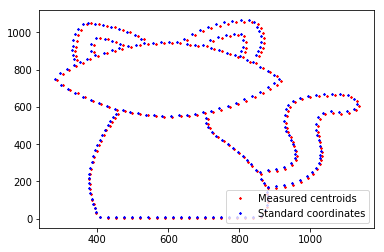

In [19]:
plt.plot(x_m, y_m, 'r*', label = "Measured centroids", ms = 2)
plt.plot(x_c, y_c, 'b*', label = "Standard coordinates", ms = 2)
plt.legend()

Have another look at the last figure: we have both measured $x_m$, $y_m$ and catalogue $x_c$, $y_c$ plotted on the same set of axes, where the catalogue values have been projected onto the plane of the CCD and manually shifted to produce a better match. To a human eye, it is obvious which catalogue point corresponds to which measured centroid. However, our algorithm does not yet know this: all it has is two sets of points, each arranged in its own arbitrary order. Furthermore, due to the imperfections in our source extraction methods, there will likely be catalogue points without identified centroids or vice versa.

Before we can proceed, we need to take the two datasets (catalogue and measured) and match the corresponding points together, discarding all those without matches. We are facing a so-called [assignment problem](https://en.wikipedia.org/wiki/Assignment_problem) to be solved by optimization. Below, I offer the most basic solution to this problem, similar to how we matched spectral lines in the previous lab. I will iterate over every measured centroid, find the catalogue point closest to it and check whether the separation is within some tolerance limit (say, 30 pixels). If it is, I will accept the point as a valid match.

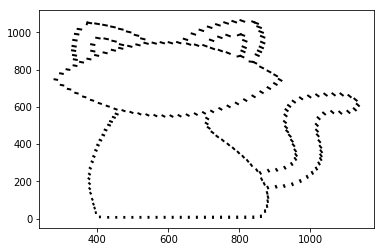

In [20]:
tolerance = 30

# Save all matched centroids in (x_measured, y_measured). Save their corresponding catalogue points in (x_cat, y_cat)
x_measured = []; y_measured = []; x_cat = []; y_cat = [];


for i, value in enumerate(x_m):
    # Find distances to all catalogue points
    distances = np.sqrt((x_m[i] - x_c) ** 2.0 + (y_m[i] - y_c) ** 2.0)
    
    # Find the closest of those and check for tolerance
    min_distance = np.min(distances)
    if min_distance > tolerance:
        continue
        
    # If we get here, the tolerance condition was passed. Save the match
    x_measured += [x_m[i]]
    y_measured += [y_m[i]]
    x_cat      += [x_c[distances == min_distance][0]]
    y_cat      += [y_c[distances == min_distance][0]]

# Plot all matches as line segments joining centroids with matched catalogue positions
for i, value in enumerate(x_measured):
    plt.plot([x_measured[i], x_cat[i]], [y_measured[i], y_cat[i]], 'k-', lw = 2)

<div class="alert alert-warning">
    Apart from points without matches, the method above suffers from another major weakness: the algorithm may misidentify matches if the points are densely clustered together. You are encouraged to improve the algorithm by adding an additional check. For example, you could try discarding all points that have "too many" matches within a small radius.
</div>

Now we are ready to begin solving for plate constants. The most general affine transformation in a 2D plane can be described with the following matrix equation:

\begin{equation*}
\begin{pmatrix}
x_m\\
y_m \\
1
\end{pmatrix} = T \begin{pmatrix}
x_c\\
y_c \\
1
\end{pmatrix}=
\begin{pmatrix}
a_{11} & a_{12} & x_0 \\
a_{21} &  a_{22} & y_0 \\
0 &  0 & 1
\end{pmatrix}
\begin{pmatrix}
x_c\\
y_c \\
1
\end{pmatrix}
\end{equation*}

<div class="alert alert-info">
    <b>FYI:</b> In the lecture notes, the transformation matrices are given before the "ideal CCD" transformation and manual translations, which is why they will have $f$ and $p$ making cameos throughout. Here, I assume that $x_c$ and $y_c$ already include that. One may also choose to absorb $f$ and $p$ into $a$ and transform from $X$ and $Y$ directly. This, however, will make the assignment problem considerably harder and this is <b>not</b> what I am doing here!
</div>

where $T$ is the transformation matrix, dependent on six free parameters ($a_{11}$, $a_{12}$, $a_{21}$ and $a_{22}$ as well as $x_0$ and $y_0$) to be determined (the so-called plate constants). $T$ is a matrix product of rotation, shear, translation and magnification. In the lectures, it was also shown that the plate constants can be solved for symbolically to obtain:

$$\begin{pmatrix}
a_{11}\\
a_{12} \\
x_0
\end{pmatrix} = (B^T B)^{-1} \ B^T \ \ \vec{x_m}\ \ \ \ \ \ \ \ \begin{pmatrix}
a_{21}\\
a_{22} \\
y_0
\end{pmatrix} = (B^T B)^{-1} \ B^T \ \ \vec{y_m}$$

You should recognize the pseudoinverse formula encountered before. Here $\vec{x_m}$ and $\vec{y_m}$ are vectors containing all $x_m$ and $y_m$ as components and $B$ is a matrix, defined as follows:

$$B=\begin{pmatrix}
x_{c1} & y_{c1} & 1 \\
x_{c2} &  y_{c2} & 1 \\
\vdots &  \vdots & \vdots
\end{pmatrix}$$

You are expected to use the linear algebra routines in Python to determine $T$ using the equations above. Start by coding in $B$ (with `np.vstack()` or otherwise), use it to obtain all $6$ plate constants and assemble the final transformation matrix out of them. You are encouraged to use the pseudoinverting routine in `np.linalg`, which will require you to simplify the equations above by introducing $B^+$.

The exercise of writing the necessary code is left up to the students. **For illustration purposes only**, the cell below computes $T$ using a built-in linear least squares optimizer from `np.linalg`:

In [21]:
# np.linalg.lstsq() solves the matrix equation a*x=b, where x is the unknown matrix and a and b are either vectors or
# arrays of vectors.

a = np.array([x_cat, y_cat, np.ones(len(y_cat))]).T
b = np.array([x_measured, y_measured, np.ones(len(y_measured))]).T
T = np.linalg.lstsq(a, b, rcond = None)[0].T

print T

[[ 9.99273420e-01  8.37623254e-03  8.80151924e-01]
 [-8.18662023e-03  1.00035260e+00 -4.94762340e-01]
 [ 5.29607449e-16 -6.03466929e-16  1.00000000e+00]]


<div class="alert alert-warning">
    In this lab, you are expected to implement your own linear least squares optimization. To do so, you will have to replace the call to the built-in routine above with your own. No points can be awarded for a code that relies on <code>np.linalg.lstsq()</code>. However, you are welcome to use <code>np.linalg.lstsq()</code> to check that your code gives correct results and you are equally welcome to use pseudoinverses.
</div>

We can now use the matrix to refine our plate solution:

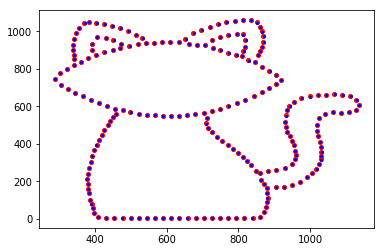

In [22]:
# Apply the matrix to every catalogue point
vector = np.matrix([x_c, y_c, 1]).T
vector_t = np.array(T * vector)
x_t, y_t = vector_t[0:2,0]

# Plot everything out
plt.plot(x_t, y_t, 'ro', ms = 4)
plt.plot(x_m, y_m, 'bo', ms = 2)

This fit hopefully looks convincing, but it is not perfect just yet. Your next mission (which you must accept regardless of whether you choose to do so) will be to plot the residuals and find mismatched points. By excluding those, it should be possible to achieve a more precise transformation.

Now we have a matrix that can transform between the catalogue coordinates and the measured centroids. With this matrix (and, of course, its inverse - the actual inverse), you can calculate the RA and Dec for any pixel on your image or vice versa (i.e., you can solve the plate).

The conversion from RA and Dec to the pixel positions involved the following steps:

* Correct for spherical distortions using the formulae in the lecture notes (or the "Astronomical catalogues" notebook). This gives us $X$ and $Y$ from $\alpha$ (RA) and $\delta$ (Dec).
* Apply the "ideal CCD" magnification and translation.
* Tune the translation terms manually until the best match is achieved (the match must be good enough to solve the assignment problem through closest distances).
* Compute $T$ with linear least squares and apply it to every point.

You should now implement a function that does all those steps in a single run (feel free to call other custom functions from it to keep your code modular!):

In [30]:
def celestial_to_pixel(ra, dec):
    """ Docstring here """
    # Your code here

Eventually, you will need to reverse this process to obtain the celestial coordinates of the asteroid. The steps would be:

* Invert $T$ and apply it.
* Subtract your manual translation terms.
* Undo the "ideal CCD" magnification and translation.
* Use the inverse trigonometric functions (more details in the lecture notes) to apply the spherical distortions back.

As before, having a single standalone function that does this will help greatly:

In [31]:
def pixel_to_celestial(x, y):
    """ Docstring here """
    # Your code here